# Assignment Head and Neck cancer

In [ ]:
# !pip install pandas sklearn
!pip install -q --upgrade git+https://github.com/Lauraartz/TM10007_PROJECT/

import hn

In [ ]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

Load data

In [ ]:
# Get data
data = pandas.read_csv('/usr/local/lib/python3.7/dist-packages/hn/HN_radiomicFeatures.csv')
feature_names = list(data.columns)
label_name = feature_names.pop(13)
feature_names.pop(0) # do not use patient ID for classification

# Replace labels T12 and T34 with 0 and 1
data = data.replace('T12', 0)
data = data.replace('T34', 1)

# Split data in test and train data
data_train, data_test = model_selection.train_test_split(data, test_size=0.2, stratify=data[label_name])
x_train = data_train[feature_names]
x_test = data_test[feature_names]
y_train = data_train[label_name]
y_test = data_test[label_name]

# convert labels to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

Feature scaling

In [ ]:
# code for feature scaling
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)
xs_train = scaler.transform(x_train)
xs_test = scaler.transform(x_test)

Feature selection

In [ ]:
# Perform a Principal Component Analysis and use the 2 main components
pca = PCA(n_components=2)
pca.fit(xs_train)
xs_train_pca = pca.transform(xs_train)
xs_test_pca = pca.transform(xs_test)

print(f"Explained variance ratio of the used components: {pca.explained_variance_ratio_}")

Explained variance ratio of the used components: [0.44978818 0.42584978]


Choose right classifier:

In [ ]:
# Create list of classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(), 
         LogisticRegression(),SGDClassifier(),KNeighborsClassifier(),DecisionTreeClassifier(),
         RandomForestClassifier(), svmlin, svmpoly, svmrbf]

# Setup split
sss = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3)

# Train the different classifiers on multiple train/validation splits and return mean accuracy
for clf in clsfs:
    results = []
    for train_index, val_index in sss.split(xs_train_pca, y_train):
        train_scores = []
        val_scores = []
        
        split_X_train = xs_train_pca[train_index]
        split_y_train = y_train[train_index]
        split_X_val = xs_train_pca[val_index]
        split_y_val = y_train[val_index]
        
        # Fit classifier
        clf.fit(split_X_train,split_y_train)

        # Get accuracy of the trained classifier on the validation set
        score = clf.score(split_X_val, split_y_val)
        results.append(score)
    
    # Print performance of the classifier 
    print(clf)
    print(f'mean accuracy: {np.mean(results)}, std: {np.std(results)}\n')


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
mean accuracy: 0.5592592592592592, std: 0.053543823314077636

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)
mean accuracy: 0.5592592592592592, std: 0.07490277191169142

GaussianNB(priors=None, var_smoothing=1e-09)
mean accuracy: 0.4851851851851852, std: 0.048148148148148155

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
mean accuracy: 0.6666666666666667, std: 0.08919699687994292

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0

Plot accuracy of training and validation set for different min_samples_leaf  values in the RandomForestClassifier


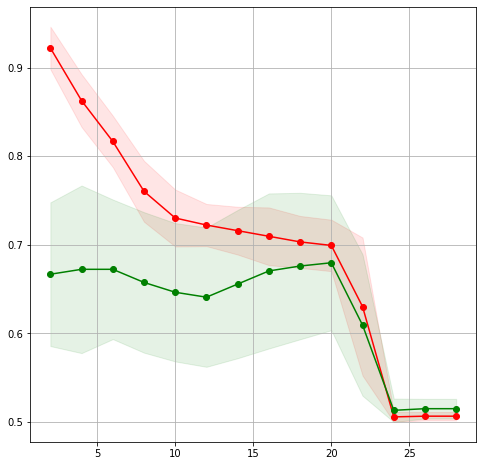

In [ ]:
# Plot train and validation accuracy for different parameter values

# Define range of min_samples_leaf values
parameter_list = list(range(2, 30, 2))

all_train = []
all_val = []

# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.3)

for train_index, val_index in sss.split(xs_train_pca, y_train):
    train_scores = []
    val_scores = []
    
    split_X_train = xs_train_pca[train_index]
    split_y_train = y_train[train_index]
    split_X_val = xs_train_pca[val_index]
    split_y_val = y_train[val_index]

    # Train the classifier for each value in parameter_list en evaluate train and validation accuracy scores
    for k in parameter_list:
        clf_rfc = RandomForestClassifier(min_samples_leaf=k)
        clf_rfc.fit(split_X_train, split_y_train)

        # Test the classifier on the training data and plot
        score_train = clf_rfc.score(split_X_train, split_y_train)
        score_val = clf_rfc.score(split_X_val, split_y_val)

        train_scores.append(score_train)
        val_scores.append(score_val)
        
    all_train.append(train_scores)
    all_val.append(val_scores)


# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_val = np.array(all_val)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

val_scores_mean = all_val.mean(axis=0)
val_scores_std = all_val.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(parameter_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(parameter_list, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1,
                     color="g")
ax.plot(parameter_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(parameter_list, val_scores_mean, 'o-', color="g",
        label="Validation score")


Initialize model

In [ ]:
clf = RandomForestClassifier(min_samples_leaf=20)

Train model on train set and measure performance on test set

In [ ]:
# train optimised desicion tree on training set
clf.fit(xs_train_pca,y_train)

# Measure accuracy of the model on test set
score = clf.score(xs_test_pca, y_test)

# Measure AUC under ROC of the model on test set
probabilities = clf.predict_proba(xs_test_pca)
scores = probabilities[:, 1]
auc = metrics.roc_auc_score(y_test, scores)

# Measure sensitivity and specificity of the model on test set
y_pred = clf.predict(xs_test_pca)
clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
sens = clf_report['1']['recall']
spec = clf_report['0']['recall']

# Print evaluation scores of the model on the test set
print(f"Accuracy: {score}")
print(f"AUC: {auc}")
print(f"Sensitivity: {sens}")
print(f"Specificity: {spec}")

Accuracy: 0.6086956521739131
AUC: 0.6477272727272727
Sensitivity: 0.45454545454545453
Specificity: 0.75


Visualization of the RandomForest classification

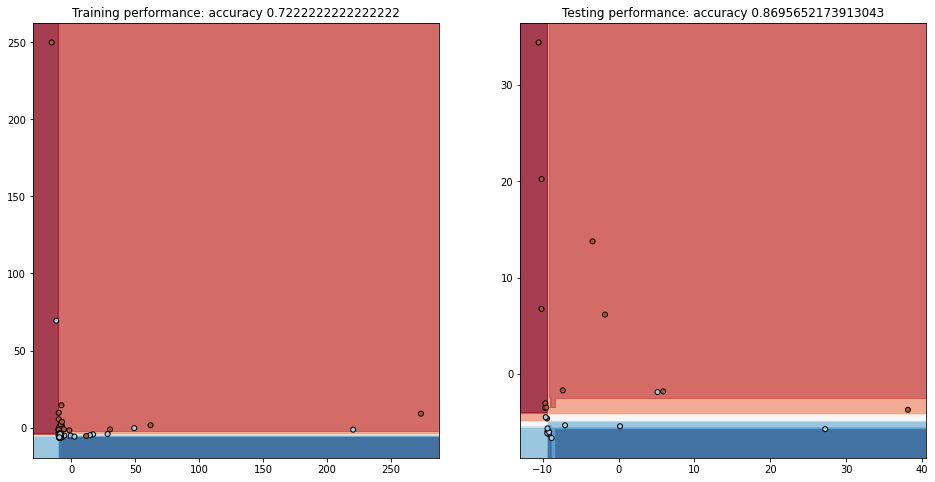

In [ ]:
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.    
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

# Figure classification on training data
train_score = clf.score(xs_train_pca, y_train)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title(f"Training performance: accuracy {train_score}")
colorplot(clf, ax, xs_train_pca[:, 0],xs_train_pca[:, 1], h=1000)
ax.scatter(xs_train_pca[:, 0], xs_train_pca[:, 1], marker='o', c=y_train,
           s=25, edgecolor='k', cmap=plt.cm.Paired)

# Figure classification on unseen test data
test_score = clf.score(xs_test_pca, y_test)
ax = fig.add_subplot(1, 2, 2)
ax.set_title(f"Testing performance: accuracy {test_score}")
colorplot(clf, ax, xs_test_pca[:, 0],xs_test_pca[:, 1], h=1000)
ax.scatter(xs_test_pca[:, 0], xs_test_pca[:, 1], marker='o', c=y_test,
           s=25, edgecolor='k', cmap=plt.cm.Paired)


Repeat model fitting and evaluation 100 times with different train/test splits and evaluate overall performance of the model

Accuracy
 mean: 0.6878260869565217 min 0.43478260869565216 max 0.8695652173913043
AUC under ROC
 mean: 0.7359469696969696 min 0.45454545454545453 max 0.9772727272727273
Sensitivity
 mean: 0.6590909090909092 min 0.2727272727272727 max 1.0
Specificity
 mean: 0.7141666666666667 min 0.3333333333333333 max 1.0
    Accuracy  AUC under ROC  Sensitivity  Specificity
0   0.782609       0.852273     0.727273     0.833333
1   0.695652       0.731061     0.636364     0.750000
2   0.739130       0.848485     0.636364     0.833333
3   0.782609       0.901515     0.636364     0.916667
4   0.695652       0.731061     0.454545     0.916667
5   0.608696       0.636364     0.545455     0.666667
6   0.695652       0.742424     0.545455     0.833333
7   0.869565       0.905303     0.909091     0.833333
8   0.478261       0.522727     0.545455     0.416667
9   0.739130       0.776515     0.727273     0.750000
10  0.652174       0.693182     0.636364     0.666667
11  0.782609       0.863636     0.636364     

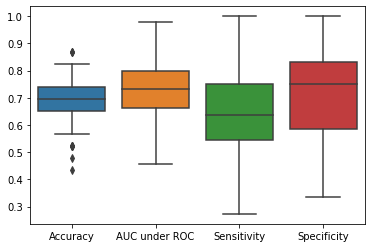

In [ ]:
# Get data
data = pandas.read_csv('/usr/local/lib/python3.7/dist-packages/hn/HN_radiomicFeatures.csv')
feature_names = list(data.columns)
label_name = feature_names.pop(13)
feature_names.pop(0) # do not use patient ID for classification

# Replace labels T12 and T34 with 0 and 1
data = data.replace('T12', 0)
data = data.replace('T34', 1)

accuracy_scores = []
sens_scores = []
spec_scores = []
auc_scores = []

for i in range(1,101):
  # Split data in test and train data
  data_train, data_test = model_selection.train_test_split(data, test_size=0.2, stratify=data[label_name])
  x_train = data_train[feature_names]
  x_test = data_test[feature_names]
  y_train = data_train[label_name]
  y_test = data_test[label_name]

  # convert labels to numpy array
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  # code for feature scaling
  scaler = preprocessing.RobustScaler()
  scaler.fit(x_train)
  xs_train = scaler.transform(x_train)
  xs_test = scaler.transform(x_test)

  # Perform a Principal Component Analysis and use the 2 main components
  pca = PCA(n_components=2)
  pca.fit(xs_train)
  xs_train_pca = pca.transform(xs_train)
  xs_test_pca = pca.transform(xs_test)

  clf = RandomForestClassifier(min_samples_leaf=20)

  # train optimised desicion tree on training set
  clf.fit(xs_train_pca,y_train)

  # Measure accuracy of the model on test set
  score = clf.score(xs_test_pca, y_test)

  # Measure AUC under ROC of the model on test set
  probabilities = clf.predict_proba(xs_test_pca)
  scores = probabilities[:, 1]
  auc = metrics.roc_auc_score(y_test, scores)

  # Measure sensitivity and specificity of the model on test set
  y_pred = clf.predict(xs_test_pca)
  clf_report = metrics.classification_report(y_test, y_pred, output_dict=True)
  sens = clf_report['1']['recall']
  spec = clf_report['0']['recall']

  accuracy_scores.append(score)
  auc_scores.append(auc)
  sens_scores.append(sens)
  spec_scores.append(spec)

# Print mean, minimum and maximum values of the outcome measures
print(f"Accuracy\n mean: {np.mean(accuracy_scores)} min {np.min(accuracy_scores)} max {np.max(accuracy_scores)}")
print(f"AUC under ROC\n mean: {np.mean(auc_scores)} min {np.min(auc_scores)} max {np.max(auc_scores)}")
print(f"Sensitivity\n mean: {np.mean(sens_scores)} min {np.min(sens_scores)} max {np.max(sens_scores)}")
print(f"Specificity\n mean: {np.mean(spec_scores)} min {np.min(spec_scores)} max {np.max(spec_scores)}")

# Save outcome measures per itteration in a DataFrame
outcome_data = pandas.DataFrame({'Accuracy': accuracy_scores,
                                 'AUC under ROC': auc_scores,
                                 'Sensitivity': sens_scores,
                                 'Specificity': spec_scores})

# Print outcome measures per itteration 
pandas.set_option('display.max_rows', None)
print(outcome_data)

# Create boxplot of the outcome measures
ax = sns.boxplot(data=outcome_data)
